In [389]:
%cd /Users/yantong/Desktop/NLP\ for\ Risk/Code/

/Users/yantong/Desktop/NLP for Risk/Code


## Import Libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [4]:
import jieba as jb
import re

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Sequential


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
 
from sklearn.model_selection import cross_val_score


In [7]:
from sklearn.model_selection import GridSearchCV


In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth",None)
pd.set_option('display.width',None)

In [9]:
import json

## Read Data

In [129]:
split_data = pd.read_csv('data_sim.csv')

In [130]:
from ast import literal_eval

In [131]:
newvalues = split_data.copy()
newvalues['baidu_seg'] = newvalues['baidu_seg'].apply(lambda row: literal_eval(row))

In [132]:
len(''.join(newvalues.loc[19852,'baidu_seg']))

421

In [133]:
newvalues.loc[19852]

Unnamed: 0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        19852
baidu_seg     [报告, 大厅, 权威, 发布, 2020年, 中国, LED, 显示屏, 上市公司, 利润, 规模, 排行榜, 一季度, 2020年, 一季度, LED, 显示屏, 上市公司, 利润, 总额, 7149.86万元, 前, 2家, 企业利润, 总额, 占, 2.21%, 榜单, 2家, 公司, 利润, 规模, 超过, 568万元, 大关, 排名前, 两家, 突破, 411万元, 568万元, 深圳雷曼光电科技股份有限公司, 太龙(福建)商业照明股份有限公司, 深圳雷曼光电科技股份有限公司, 成为, 2020年, LED, 显示屏, 利润, 规模, 最大, 中国, 公司, 利润, 高达, 411.13万元, 太龙(福建)商业照明股份有限公司, 紧随, 其后, 利润, 达到, 568.84万元, 具体, 详细, 排名, 情况, 报告, 大厅, 2020年, 中国, LED, 显示屏, 上市公司, 利润, 规模, 排行榜, 一季度, 数据, 统计, 显示, 前, 4家, 利润, 总额, 企业,

In [134]:
newvalues = newvalues[['baidu_seg','baidu_prob']]

## Data Preparation

In [135]:
newvalues['label'] = newvalues['baidu_prob'].apply(lambda row: 1 if row>0.5 else 0)

<AxesSubplot:>

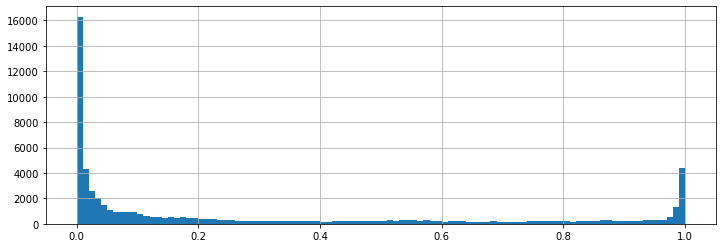

In [678]:
newvalues.baidu_prob.hist(bins = 100)

In [136]:
newvalues.label.value_counts()

0    48947
1    17813
Name: label, dtype: int64

In [137]:
newvalues.shape

(66760, 3)

#### 删除 \u3000

In [161]:
def del_u3000(lst):
    lst = [x for x in lst if not '\\u3000' in x]
    return lst

In [162]:
newvalues.baidu_seg = newvalues.baidu_seg.apply(lambda s: [x for x in s if not '\\u3000' in x])

#### 统计segmentation字数

In [163]:
len(''.join(newvalues.loc[19852,'baidu_seg']))

421

In [164]:
newvalues['word_counts'] = newvalues.baidu_seg.apply(lambda row: len(''.join(row)))

<AxesSubplot:>

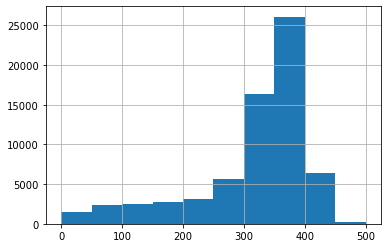

In [165]:
newvalues.word_counts.hist()

In [186]:
newvalues[newvalues.word_counts <= 150].shape

(6402, 4)

In [187]:
newvalues = newvalues[newvalues.word_counts > 150]
newvalues = newvalues.reset_index()

In [188]:
newvalues = newvalues.drop(['index'],axis = 1)

In [55]:
#newvalues.loc[10257]

In [189]:
for i in range(newvalues.shape[0]):
    if len(newvalues.loc[i,'baidu_seg']) == 20:
        print(i)

In [190]:
newvalues.loc[19852,'baidu_prob']

0.441775

In [404]:
#newvalues.loc[19852,'baidu_seg']

In [94]:
# 19852,28322
newvalues = newvalues.drop(28322)

In [95]:
# 19852,28322
newvalues = newvalues.drop(28322)
newvalues = newvalues.reset_index()

## Imbalanced

In [192]:
from collections import Counter
Counter(newvalues.label)

Counter({0: 43784, 1: 16574})

### Resampling -- Oversampling

In [97]:
X = np.array(newvalues.baidu_seg).reshape(-1,1)
y = newvalues.label

#### Naive Ramdom Over-sampling

In [373]:
from imblearn.over_sampling import RandomOverSampler

In [376]:
X = newvalues['baidu_seg']
y = newvalues['label']

## Modelling

In [533]:
# performance
performance_df = pd.DataFrame()


In [534]:
def perform(model_name,performance,performance_df):
    perform_1 = pd.DataFrame(performance['detail']['1'],index = [model_name])
    perform_0 = pd.DataFrame(performance['detail']['0'],index = [model_name])
    perform_macro = pd.DataFrame(performance['detail']['macro avg'],index = [model_name])
    perform_weighted = pd.DataFrame(performance['detail']['weighted avg'],index = [model_name])
    performance_model = pd.DataFrame()
    performance_model.loc[model_name,'accuracy'] = performance['detail']['accuracy']    
    
    performance_model = pd.concat([performance_model,perform_1,perform_0,perform_macro,perform_weighted],axis = 1)    
    performance_df = pd.concat([performance_df,performance_model],axis = 0)
    return performance_df

In [535]:
# performance = cnn_performance
# model_name = 'cnn'
# performance_df = perform(model_name,performance,performance_df)
# performance_df

In [536]:
# performance

def sklearn_perform(model_name,performance,performance_df):
    perform_1 = pd.DataFrame(performance['1'],index = [model_name])
    perform_0 = pd.DataFrame(performance['0'],index = [model_name])
    perform_macro = pd.DataFrame(performance['macro avg'],index = [model_name])
    perform_weighted = pd.DataFrame(performance['weighted avg'],index = [model_name])
    performance_model = pd.DataFrame()
    performance_model.loc[model_name,'accuracy'] = performance['accuracy']    
    
    performance_model = pd.concat([performance_model,perform_1,perform_0,perform_macro,perform_weighted],axis = 1)    
    performance_df = pd.concat([performance_df,performance_model],axis = 0)
    return performance_df

### Model 1.1: TF-IDF + CNN

In [198]:
import kashgari
from kashgari import utils
from kashgari.embeddings import BertEmbedding
from kashgari.tasks.labeling import BiLSTM_CRF_Model
# from data_load import DataReader

In [199]:
from sklearn.model_selection import train_test_split


In [200]:
from tensorflow.keras.callbacks import TensorBoard
from kashgari.tasks.classification import CNN_Model

In [201]:
#from sklearn.feature_extraction.text import TfidfVectorizer
 
#tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
#vectorizer = CountVectorizer()    
#features = tfidf.fit_transform(vectorizer.fit_transform(labeled_data_3.content_cut))
#labels = labeled_data_3.label
#print(features.shape)
#print('-----------------------------')
#print(features)
#print(labels)

In [202]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, 
                                                                                 newvalues.index, 
                                                                                 test_size=0.2, stratify=y, random_state=0)
X_test = X_test.tolist()
y_test = y_test.tolist()



X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X_train, y_train, 
                                                                                 indices_train, 
                                                                                 test_size=0.05, stratify=y_train, random_state=0)

X_train = X_train.tolist()
y_train = y_train.tolist()
X_val = X_val.tolist()
y_val = y_val.tolist()



In [204]:
# Using TensorBoard record training process
tf_board = TensorBoard(log_dir='tf_dir/cnn_model_split_fb_wx',
                       histogram_freq=5,
                       update_freq='batch')


In [205]:
model = CNN_Model()
model.fit(X_train, y_train, X_val, y_val,
          batch_size=128,
          callbacks=[tf_board])

Preparing text vocab dict: 100%|██████████| 2415/2415 [00:00<00:00, 17442.62it/s]
2021-01-04 10:50:12,169 [DEBUG] kashgari - --- Build vocab dict finished, Total: 100895 ---
2021-01-04 10:50:12,170 [DEBUG] kashgari - Top-10: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '项目', '企业', '工程', '建设', '公司', '施工']
Calculating sequence length: 100%|██████████| 2415/2415 [00:00<00:00, 1132644.99it/s]
2021-01-04 10:50:12,443 [DEBUG] kashgari - Calculated sequence length = 185
2021-01-04 10:50:12,509 [DEBUG] kashgari - Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
layer_embedding (Embedding)  (None, None, 100)         10089500  
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         64128     
__________________

Epoch 1/5
358/358 [==============================] - 46s 126ms/step - loss: 0.4591 - accuracy: 0.7834 - val_loss: 0.2712 - val_accuracy: 0.8819
Epoch 2/5
358/358 [==============================] - 41s 115ms/step - loss: 0.1991 - accuracy: 0.9170 - val_loss: 0.3077 - val_accuracy: 0.8811
Epoch 3/5
358/358 [==============================] - 44s 123ms/step - loss: 0.0496 - accuracy: 0.9851 - val_loss: 0.3724 - val_accuracy: 0.8789
Epoch 4/5
358/358 [==============================] - 44s 122ms/step - loss: 0.0149 - accuracy: 0.9967 - val_loss: 0.3754 - val_accuracy: 0.8824
Epoch 5/5
358/358 [==============================] - 44s 124ms/step - loss: 0.0074 - accuracy: 0.9987 - val_loss: 0.4024 - val_accuracy: 0.8828


In [206]:
import os
import joblib
os.chdir("saved_model_split_fb_wx")
model.save('tfidf_cnn')

FileNotFoundError: [Errno 2] No such file or directory: 'saved_model_split_fb_wx'

In [207]:
os.chdir("..")

In [358]:
tf_idf_cnn_performance = model.evaluate(X_test, y_test)

2021-01-04 14:15:20,315 [DEBUG] kashgari - predict input shape (12072, 235) x: 
[[    2 11479  4327 ...     0     0     0]
 [    2   192  1224 ...     0     0     0]
 [    2  4194  3815 ...     0     0     0]
 ...
 [    2   800  2610 ...     0     0     0]
 [    2  3817  9021 ...     0     0     0]
 [    2   423  4906 ...     0     0     0]]
2021-01-04 14:15:22,420 [DEBUG] kashgari - predict output shape (12072, 2)
2021-01-04 14:15:22,429 [DEBUG] kashgari - predict output argmax: [0 1 1 ... 0 0 0]


              precision    recall  f1-score   support

           0     0.9229    0.9026    0.9126      8757
           1     0.7568    0.8009    0.7783      3315

    accuracy                         0.8747     12072
   macro avg     0.8399    0.8517    0.8454     12072
weighted avg     0.8773    0.8747    0.8757     12072



In [537]:
performance = tf_idf_cnn_performance
model_name = 'TF-IDF_CNN'
performance_df = perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.77825,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.84545,12072,0.877324,0.874669,0.875743,12072


### Model 1.2: TF-IDF + CNN + Naive Random Sampling

In [377]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, 
                                                                                 newvalues.index, 
                                                                                 test_size=0.2, stratify=y, random_state=0)
X_test = X_test.tolist()
y_test = y_test.tolist()

X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X_train, y_train, 
                                                                                 indices_train, 
                                                                                 test_size=0.05, stratify=y_train, random_state=0)

X_train = X_train.tolist()
y_train = y_train.tolist()
X_val = X_val.tolist()
y_val = y_val.tolist()

In [378]:
X_resampling = np.array(X_train).reshape(-1,1)
y_resampling = y_train
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [379]:
# Using TensorBoard record training process
tf_board = TensorBoard(log_dir='tf_dir/cnn_model_naive_resampling_split_fb_wx',
                       histogram_freq=5,
                       update_freq='batch')


In [381]:
model = CNN_Model()
model.fit(X_train, y_train, X_val, y_val,
          batch_size=128,
          callbacks=[tf_board])

Preparing text vocab dict: 100%|██████████| 2415/2415 [00:00<00:00, 25104.76it/s]
2021-01-04 14:19:52,294 [DEBUG] kashgari - --- Build vocab dict finished, Total: 100895 ---
2021-01-04 14:19:52,295 [DEBUG] kashgari - Top-10: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '项目', '企业', '工程', '建设', '公司', '施工']
Calculating sequence length: 100%|██████████| 2415/2415 [00:00<00:00, 1187345.46it/s]
2021-01-04 14:19:52,504 [DEBUG] kashgari - Calculated sequence length = 185
2021-01-04 14:19:52,546 [DEBUG] kashgari - Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
layer_embedding (Embedding)  (None, None, 100)         10089500  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         64128     
__________________

Epoch 1/5
358/358 [==============================] - 47s 130ms/step - loss: 0.4612 - accuracy: 0.7763 - val_loss: 0.2643 - val_accuracy: 0.8906
Epoch 2/5
358/358 [==============================] - 47s 131ms/step - loss: 0.1984 - accuracy: 0.9173 - val_loss: 0.3045 - val_accuracy: 0.8789
Epoch 3/5
358/358 [==============================] - 45s 126ms/step - loss: 0.0520 - accuracy: 0.9839 - val_loss: 0.3800 - val_accuracy: 0.8845
Epoch 4/5
358/358 [==============================] - 46s 128ms/step - loss: 0.0174 - accuracy: 0.9960 - val_loss: 0.4136 - val_accuracy: 0.8872
Epoch 5/5
358/358 [==============================] - 45s 126ms/step - loss: 0.0082 - accuracy: 0.9985 - val_loss: 0.4391 - val_accuracy: 0.8845


In [390]:
import os
import joblib
os.chdir("saved_model_split_fb_wx")
model.save('tfidf_cnn_naive_resampling')

2021-01-04 14:25:07,781 [INFO] kashgari - model saved to /Users/yantong/Desktop/NLP for Risk/Code/saved_model_split_fb_wx/tfidf_cnn_naive_resampling


'/Users/yantong/Desktop/NLP for Risk/Code/saved_model_split_fb_wx/tfidf_cnn_naive_resampling'

In [391]:
os.chdir("..")

In [392]:
tfidf_cnn_naive_resampling_performance = model.evaluate(X_test, y_test)

2021-01-04 14:25:19,876 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 235
2021-01-04 14:25:21,075 [DEBUG] kashgari - predict input shape (12072, 235) x: 
[[    2 11479  4327 ...     0     0     0]
 [    2   192  1224 ...     0     0     0]
 [    2  4194  3815 ...     0     0     0]
 ...
 [    2   800  2610 ...     0     0     0]
 [    2  3817  9021 ...     0     0     0]
 [    2   423  4906 ...     0     0     0]]
2021-01-04 14:25:22,925 [DEBUG] kashgari - predict output shape (12072, 2)
2021-01-04 14:25:22,934 [DEBUG] kashgari - predict output argmax: [0 1 1 ... 0 0 0]


              precision    recall  f1-score   support

           0     0.9009    0.9415    0.9208      8757
           1     0.8247    0.7264    0.7724      3315

    accuracy                         0.8825     12072
   macro avg     0.8628    0.8340    0.8466     12072
weighted avg     0.8800    0.8825    0.8800     12072



In [538]:
performance = tfidf_cnn_naive_resampling_performance
model_name = 'TF-IDF_CNN_naive_resampling'
performance_df = perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.84545,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.84659,12072,0.879961,0.882455,0.880028,12072


### Model 2.1: 现有样本训练Word2Vec + LR

In [474]:
with open('./stopwords.txt', encoding='utf8') as file:
    line_list = file.readlines()
    stopword_list = [k.strip() for k in line_list]
    stopword_set = set(stopword_list)
    print('停顿词列表，即变量stopword_list中共有%d个元素' %len(stopword_list))
    print('停顿词集合，即变量stopword_set中共有%d个元素' %len(stopword_set))

停顿词列表，即变量stopword_list中共有782个元素
停顿词集合，即变量stopword_set中共有782个元素


In [475]:
#cutWords_List = []
#startTime = time.time()
#content_series = newvalues['baidu_seg']
#for i in range(len(content_series)):
#    content = content_series.iloc[i]
#    cutWords = [k for k in content]
#    if (i + 1) % 3000 == 0:
#        usedTime = time.time() - startTime
#        print('前%d篇文章分词共花费%.2f秒' %(i+1, usedTime))
#    cutWords_list.append(cutWords)

In [476]:
cutWords_list = newvalues['baidu_seg']

In [477]:
import time
from gensim.models import Word2Vec
startTime = time.time()
word2vec_model = Word2Vec(cutWords_list, size=200, iter=10, min_count=20)
usedTime = time.time() - startTime
print('形成word2vec模型共花费%.2f秒' %usedTime)

形成word2vec模型共花费77.95秒


In [478]:
import warnings
warnings.filterwarnings('ignore')

In [479]:
word2vec_model.wv.most_similar('建筑')
# word2vec_model.similarity('治愈','感染')

[('建筑工程', 0.6472513675689697),
 ('建筑业', 0.4788665175437927),
 ('建筑类', 0.4670443832874298),
 ('装配式建筑', 0.4594500958919525),
 ('建筑设计', 0.4360891282558441),
 ('绿色建筑', 0.4348108470439911),
 ('钢结构', 0.417186975479126),
 ('装修', 0.40588676929473877),
 ('市政工程', 0.40299978852272034),
 ('工程造价', 0.3887310326099396)]

#### Word2Vec 

In [480]:
import numpy as np

def get_contentVector(cutWords, word2vec_model):
    vector_list = [word2vec_model.wv[k] for k in cutWords if k in word2vec_model]
    contentVector = np.array(vector_list).mean(axis=0)
    return contentVector

In [481]:
import time

startTime = time.time()
contentVector_list = []
for i in range(len(cutWords_list)):
    cutWords = cutWords_list[i]
    if (i+1) % 3000 == 0:
        usedTime = time.time() - startTime
        print('前%d篇文章内容表示成向量共花费%.2f秒' %(i+1, usedTime))
    contentVector_list.append(list(get_contentVector(cutWords, word2vec_model)))
X = np.array(contentVector_list)

In [498]:
X.shape # check

(60342, 200)

In [504]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
y = list(labelEncoder.fit_transform(newvalues['label']))

In [506]:
#word2vec_gb_wx = pd.DataFrame(X)
#word2vec_gb_wx['label'] = y

In [509]:
#word2vec_gb_wx.to_csv('word2vec_gb_wx.csv')

In [472]:
# remove data points
# 13709 * 5 ,29981 * 2,37189, 37764 * 4
# 地名 重复数字
#newvalues = newvalues.drop(37764)
#newvalues = newvalues.reset_index()
#newvalues = newvalues.drop(['index'],axis = 1)


In [473]:
#newvalues.loc[37189]

baidu_seg      [工程, 建设, 项目, 建设, 团队, 始终, 坚持, 严格, 控, 项目, 质量, 管理, 不断, 完善, 各项, 质量, 管理, 制度, 注重, 过程, 监督, 检查, 加强, 试验, 测量, 原材料, 管控, 影响, 工程, 实体, 质量, 环节, 进行, 重点, 检查, 开展, 质量, 通病, 治理, 不断, 改进, 施工, 工艺, 工程, 质量, 管理, 取得, 显著, 成效, 检测, 桥梁, 涵洞, 几何, 尺寸, 控制, 准确, 曲线, 流畅, 混凝土, 平整, 密实, 光洁, 美观, 隧道, 工程, 结构, 安全, 可靠, 沥青, 路面, 行车, 平稳, 舒适, 绿化, 实现, 全, 覆盖, 互通, 隧道, 两端, 采用, 保护, 原生, 植物, 方式, 极大, 提高, 绿化, 观赏性, 实现, 工程, 自然景观, 完美, 融合, 项目, 竣工, 验收, 综合, 得分, 96.5分, ...]
baidu_prob                                                                                                                                                                                                                                                                                                                                                                                                                      0.00104759
label                                                                                                                                             

#### Logistic Regression Models

In [510]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [511]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [512]:
X = np.array(X)

In [513]:
train_X_lr, test_X_lr, train_y_lr, test_y_lr = train_test_split(X, y, test_size=0.2)

In [514]:
logisticRegression_model = LogisticRegression()
logisticRegression_model.fit(train_X_lr, train_y_lr)
logisticRegression_model.score(test_X_lr, test_y_lr)

0.8692518021377081

In [515]:
y_pred_lr = logisticRegression_model.predict(test_X_lr)

In [516]:
print(classification_report(test_y_lr, y_pred_lr,digits=4))

              precision    recall  f1-score   support

           0     0.8928    0.9312    0.9116      8741
           1     0.7964    0.7064    0.7487      3328

    accuracy                         0.8693     12069
   macro avg     0.8446    0.8188    0.8302     12069
weighted avg     0.8662    0.8693    0.8667     12069



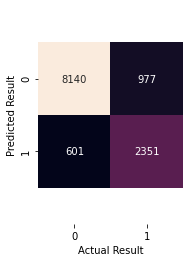

In [517]:
mat = confusion_matrix( y_pred_lr,test_y_lr)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [518]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [519]:
predslog = logisticRegression_model.predict_proba(test_X_lr)[:,1]
metrics.roc_auc_score(test_y_lr,predslog, average='macro', sample_weight=None)

0.9287204682508602

In [520]:
def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')

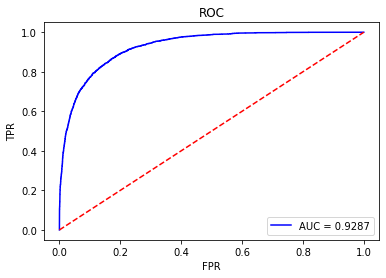

In [521]:
plot_roc(test_y_lr,predslog)

In [540]:
fbwx_w2v_lr_performance = classification_report(test_y_lr, y_pred_lr,digits=4,output_dict=True)
performance = fbwx_w2v_lr_performance
model_name = 'fbwx_w2v_LR'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069


### Model 2.2: 现有样本训练Word2Vec + LR + Naive Resampling

In [541]:
X = newvalues['baidu_seg']
y = newvalues['label']

AttributeError: 'numpy.ndarray' object has no attribute 'head'

#### Word2Vec

In [542]:
cutWords_list = newvalues['baidu_seg']

startTime = time.time()
contentVector_list = []
for i in range(len(cutWords_list)):
    cutWords = cutWords_list[i]
#    if (i+1) % 3000 == 0:
#        usedTime = time.time() - startTime
#        print('前%d篇文章内容表示成向量共花费%.2f秒' %(i+1, usedTime))
    contentVector_list.append(list(get_contentVector(cutWords, word2vec_model)))
X = np.array(contentVector_list)

In [543]:
X = np.array(X)

In [544]:
train_X_lr, test_X_lr, train_y_lr, test_y_lr = train_test_split(X, y, test_size=0.2)

In [545]:
X_resampling = np.array(train_X_lr)
y_resampling = train_y_lr
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)

In [546]:
logisticRegression_model = LogisticRegression()
logisticRegression_model.fit(X_resampled_naive, y_resampled_naive)
logisticRegression_model.score(test_X_lr, test_y_lr)
#logisticRegression_model.score(X_resampling, y_resampling)

0.869086088325462

In [547]:
y_pred_lr = logisticRegression_model.predict(test_X_lr)

In [548]:
print(classification_report(test_y_lr, y_pred_lr,digits=4))

              precision    recall  f1-score   support

           0     0.8930    0.9320    0.9121      8792
           1     0.7933    0.7003    0.7439      3277

    accuracy                         0.8691     12069
   macro avg     0.8431    0.8162    0.8280     12069
weighted avg     0.8659    0.8691    0.8664     12069



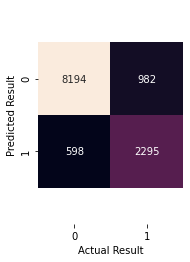

In [549]:
mat = confusion_matrix( y_pred_lr,test_y_lr)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [550]:
predslog = logisticRegression_model.predict_proba(test_X_lr)[:,1]
metrics.roc_auc_score(test_y_lr,predslog, average='macro', sample_weight=None)

0.9280954014565909

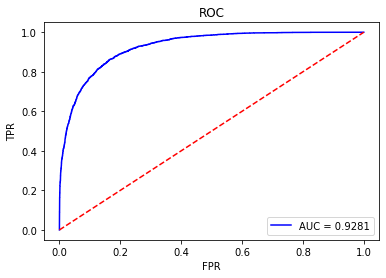

In [551]:
plot_roc(test_y_lr,predslog)

In [552]:
fbwx_w2v_lr_naive_resampling_performance = classification_report(test_y_lr, y_pred_lr,digits=4,output_dict=True)
performance = fbwx_w2v_lr_naive_resampling_performance
model_name = 'fbwx_w2v_LR_naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069


### Model 3.1: 现有样本训练Word2Vec + SVM

In [553]:
#训练模型
model_svm = LinearSVC()
train_X_svm, test_X_svm, train_y_svm, test_y_svm = train_test_split(X, y, test_size=0.2)


In [554]:
model_svm.fit(train_X_svm, train_y_svm)
y_pred_svm = model_svm.predict(test_X_svm)

In [555]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.8896    0.9320    0.9103      8716
           1     0.7982    0.6994    0.7455      3353

    accuracy                         0.8673     12069
   macro avg     0.8439    0.8157    0.8279     12069
weighted avg     0.8642    0.8673    0.8645     12069



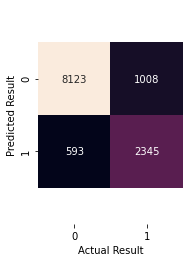

In [556]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [561]:
fbwx_w2v_linear_SVM_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_linear_SVM_performance
model_name = 'fbwx_w2v_linear_SVM'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069


### Model 3.2 现有样本训练Word2Vec + SVM + Naive Resampling

In [566]:
model_svm_sampling = LinearSVC()


In [567]:
X_resampling = np.array(train_X_svm)
y_resampling = train_y_svm
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)


In [575]:
model_svm_sampling.fit(X_resampled_naive, y_resampled_naive)
y_pred_svm = model_svm_sampling.predict(test_X_svm)

In [576]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9386    0.8347    0.8836      8716
           1     0.6663    0.8580    0.7501      3353

    accuracy                         0.8412     12069
   macro avg     0.8024    0.8464    0.8168     12069
weighted avg     0.8629    0.8412    0.8465     12069



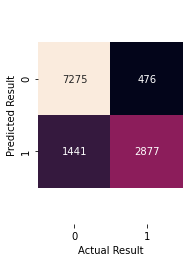

In [578]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [579]:
fbwx_w2v_linear_SVM_naive_resampling_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_linear_SVM_naive_resampling_performance
model_name = 'fbwx_w2v_linear_SVM_naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df


,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069
fbwx_w2v_linear_SVM_naive_resampling,0.841163,0.666281,0.858038,0.750098,3353,0.938589,0.834672,0.883585,8716,0.802435,0.846355,0.816842,12069,0.862936,0.841163,0.846500,12069


### Model 3.3 现有样本训练Word2Vec + kernal_SVM

In [580]:
from sklearn.svm import SVC

#### SVC(kernel = 'poly', C = 0.1)

In [581]:
kernal_svm = SVC(kernel = 'poly', C = 0.1)
kernal_svm.fit(train_X_svm,train_y_svm)

SVC(C=0.1, kernel='poly')

In [582]:
y_pred_svm = kernal_svm.predict(test_X_svm)

In [583]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.8517    0.9615    0.9033      8716
           1     0.8493    0.5649    0.6785      3353

    accuracy                         0.8513     12069
   macro avg     0.8505    0.7632    0.7909     12069
weighted avg     0.8510    0.8513    0.8408     12069



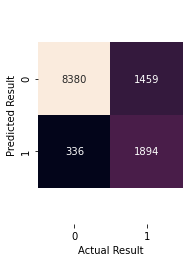

In [584]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [585]:
fbwx_w2v_poly_SVM_C0_1_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_poly_SVM_C0_1_performance
model_name = 'fbwx_w2v_poly_SVM C=0.1'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df


,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069
fbwx_w2v_linear_SVM_naive_resampling,0.841163,0.666281,0.858038,0.750098,3353,0.938589,0.834672,0.883585,8716,0.802435,0.846355,0.816842,12069,0.862936,0.841163,0.846500,12069
fbwx_w2v_poly_SVM C=0.1,0.851272,0.849327,0.564867,0.678488,3353,0.851713,0.961450,0.903261,8716,0.850520,0.763159,0.790874,12069,0.851050,0.851272,0.840815,12069


#### kernal_svm = SVC(kernel = 'poly', C = 1)

In [587]:
kernal_svm = SVC(kernel = 'poly', C = 1)
kernal_svm.fit(train_X_svm,train_y_svm)

SVC(C=1, kernel='poly')

In [588]:
y_pred_svm = kernal_svm.predict(test_X_svm)

In [589]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.8890    0.9469    0.9171      8716
           1     0.8338    0.6928    0.7568      3353

    accuracy                         0.8763     12069
   macro avg     0.8614    0.8198    0.8369     12069
weighted avg     0.8737    0.8763    0.8725     12069



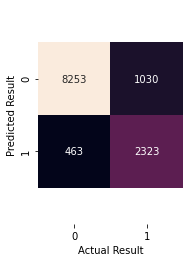

In [590]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [591]:
fbwx_w2v_poly_SVM_C1_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_poly_SVM_C1_performance
model_name = 'fbwx_w2v_poly_SVM C=1'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069
fbwx_w2v_linear_SVM_naive_resampling,0.841163,0.666281,0.858038,0.750098,3353,0.938589,0.834672,0.883585,8716,0.802435,0.846355,0.816842,12069,0.862936,0.841163,0.846500,12069
fbwx_w2v_poly_SVM C=0.1,0.851272,0.849327,0.564867,0.678488,3353,0.851713,0.961450,0.903261,8716,0.850520,0.763159,0.790874,12069,0.851050,0.851272,0.840815,12069
fbwx_w2v_poly_SVM C=1,0.876295,0.833812,0.692812,0.756801,3353,0.889044,0.946879,0.917051,8716,0.861428,0.819846,0.836926,12069,0.873700,0.876295,0.872530,12069


### Model 3.4 现有样本训练Word2Vec + kernal_SVM + Naive Resampling
* 可能是做了不平衡处理的原因，模型更偏向于预测样本为负类。不过也不算一件坏事。recall得以提升，代价是降低的precision。模型更为贪婪。
    * recall高：宁错杀不放过
    * precision高：不冤枉好人
* 样本增加 调整参数C的值。C = 1 的表现由于 C = 0.1

In [592]:
X_resampling = np.array(train_X_svm)
y_resampling = train_y_svm
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)


#### kernal_svm = SVC(kernel = 'poly', C = 0.1)

In [593]:
kernal_svm = SVC(kernel = 'poly', C = 0.1)
kernal_svm.fit(X_resampled_naive,y_resampled_naive)

SVC(C=0.1, kernel='poly')

In [594]:
y_pred_svm = kernal_svm.predict(test_X_svm)

In [595]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9406    0.8341    0.8842      8716
           1     0.6668    0.8631    0.7524      3353

    accuracy                         0.8422     12069
   macro avg     0.8037    0.8486    0.8183     12069
weighted avg     0.8645    0.8422    0.8475     12069



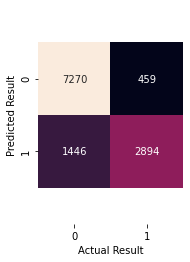

In [596]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim()
a += 0.5 
b -= 0.5 
plt.ylim(a, b)
plt.show()

In [597]:
fbwx_w2v_poly_SVM_C0_1_naive_resampling_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_poly_SVM_C0_1_naive_resampling_performance
model_name = 'fbwx_w2v_poly_SVM(C=0.1)_naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df


,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069
fbwx_w2v_linear_SVM_naive_resampling,0.841163,0.666281,0.858038,0.750098,3353,0.938589,0.834672,0.883585,8716,0.802435,0.846355,0.816842,12069,0.862936,0.841163,0.846500,12069
fbwx_w2v_poly_SVM C=0.1,0.851272,0.849327,0.564867,0.678488,3353,0.851713,0.961450,0.903261,8716,0.850520,0.763159,0.790874,12069,0.851050,0.851272,0.840815,12069
fbwx_w2v_poly_SVM C=1,0.876295,0.833812,0.692812,0.756801,3353,0.889044,0.946879,0.917051,8716,0.861428,0.819846,0.836926,12069,0.873700,0.876295,0.872530,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.842158,0.666820,0.863108,0.752372,3353,0.940613,0.834098,0.884159,8716,0.803717,0.848603,0.818266,12069,0.864548,0.842158,0.847546,12069


#### kernal_svm = SVC(kernel = 'poly', C = 1)


In [598]:
kernal_svm = SVC(kernel = 'poly', C = 1)
kernal_svm.fit(X_resampled_naive,y_resampled_naive)

SVC(C=1, kernel='poly')

In [599]:
y_pred_svm = kernal_svm.predict(test_X_svm)

In [600]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9428    0.8630    0.9012      8716
           1     0.7081    0.8640    0.7783      3353

    accuracy                         0.8633     12069
   macro avg     0.8255    0.8635    0.8398     12069
weighted avg     0.8776    0.8633    0.8670     12069



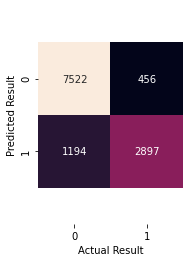

In [601]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [602]:
fbwx_w2v_poly_SVM_C1_naive_resampling_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_poly_SVM_C1_naive_resampling_performance
model_name = 'fbwx_w2v_poly_SVM(C=1)_naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069
fbwx_w2v_linear_SVM_naive_resampling,0.841163,0.666281,0.858038,0.750098,3353,0.938589,0.834672,0.883585,8716,0.802435,0.846355,0.816842,12069,0.862936,0.841163,0.846500,12069
fbwx_w2v_poly_SVM C=0.1,0.851272,0.849327,0.564867,0.678488,3353,0.851713,0.961450,0.903261,8716,0.850520,0.763159,0.790874,12069,0.851050,0.851272,0.840815,12069
fbwx_w2v_poly_SVM C=1,0.876295,0.833812,0.692812,0.756801,3353,0.889044,0.946879,0.917051,8716,0.861428,0.819846,0.836926,12069,0.873700,0.876295,0.872530,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.842158,0.666820,0.863108,0.752372,3353,0.940613,0.834098,0.884159,8716,0.803717,0.848603,0.818266,12069,0.864548,0.842158,0.847546,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.863286,0.708140,0.864002,0.778345,3353,0.942843,0.863011,0.901162,8716,0.825491,0.863506,0.839754,12069,0.877638,0.863286,0.867041,12069


### Model 3.5 现有样本训练Word2Vec + RBF_SVM 
rbf SVM 有较大的提升
计算时间太长，一个模型跑了30+ min

In [603]:
rbf_svm = SVC(C=1.0, kernel='rbf', gamma=0.1)
rbf_svm.fit(train_X_svm,train_y_svm)

SVC(gamma=0.1)

In [604]:
y_pred_svm = rbf_svm.predict(test_X_svm)

In [605]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.8978    0.9433    0.9200      8716
           1     0.8303    0.7208    0.7717      3353

    accuracy                         0.8815     12069
   macro avg     0.8640    0.8321    0.8459     12069
weighted avg     0.8790    0.8815    0.8788     12069



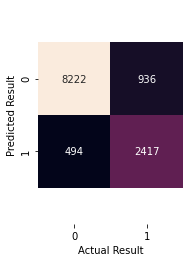

In [606]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [607]:
fbwx_w2v_rbf_SVM_gm0_1_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_rbf_SVM_gm0_1_performance
model_name = 'fbwx_w2v_rbf_SVM(gamma=0.1)'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df


,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069
fbwx_w2v_linear_SVM_naive_resampling,0.841163,0.666281,0.858038,0.750098,3353,0.938589,0.834672,0.883585,8716,0.802435,0.846355,0.816842,12069,0.862936,0.841163,0.846500,12069
fbwx_w2v_poly_SVM C=0.1,0.851272,0.849327,0.564867,0.678488,3353,0.851713,0.961450,0.903261,8716,0.850520,0.763159,0.790874,12069,0.851050,0.851272,0.840815,12069
fbwx_w2v_poly_SVM C=1,0.876295,0.833812,0.692812,0.756801,3353,0.889044,0.946879,0.917051,8716,0.861428,0.819846,0.836926,12069,0.873700,0.876295,0.872530,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.842158,0.666820,0.863108,0.752372,3353,0.940613,0.834098,0.884159,8716,0.803717,0.848603,0.818266,12069,0.864548,0.842158,0.847546,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.863286,0.708140,0.864002,0.778345,3353,0.942843,0.863011,0.901162,8716,0.825491,0.863506,0.839754,12069,0.877638,0.863286,0.867041,12069


### Model 3.6 现有样本训练Word2Vec + RBF_SVM + Naive Resampling

In [608]:
rbf_svm = SVC(C=1.0, kernel='rbf', gamma=0.1)
rbf_svm.fit(X_resampled_naive,y_resampled_naive)

SVC(gamma=0.1)

In [609]:
y_pred_svm = rbf_svm.predict(test_X_svm)

In [610]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9309    0.8869    0.9083      8716
           1     0.7381    0.8288    0.7808      3353

    accuracy                         0.8707     12069
   macro avg     0.8345    0.8578    0.8446     12069
weighted avg     0.8773    0.8707    0.8729     12069



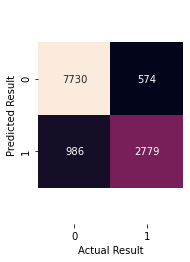

In [611]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [612]:
fbwx_w2v_rbf_SVM_gm0_1_naive_resampling_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_rbf_SVM_gm0_1_naive_resampling_performance
model_name = 'fbwx_w2v_rbf_SVM(gamma=0.1)_naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069
fbwx_w2v_linear_SVM_naive_resampling,0.841163,0.666281,0.858038,0.750098,3353,0.938589,0.834672,0.883585,8716,0.802435,0.846355,0.816842,12069,0.862936,0.841163,0.846500,12069
fbwx_w2v_poly_SVM C=0.1,0.851272,0.849327,0.564867,0.678488,3353,0.851713,0.961450,0.903261,8716,0.850520,0.763159,0.790874,12069,0.851050,0.851272,0.840815,12069
fbwx_w2v_poly_SVM C=1,0.876295,0.833812,0.692812,0.756801,3353,0.889044,0.946879,0.917051,8716,0.861428,0.819846,0.836926,12069,0.873700,0.876295,0.872530,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.842158,0.666820,0.863108,0.752372,3353,0.940613,0.834098,0.884159,8716,0.803717,0.848603,0.818266,12069,0.864548,0.842158,0.847546,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.863286,0.708140,0.864002,0.778345,3353,0.942843,0.863011,0.901162,8716,0.825491,0.863506,0.839754,12069,0.877638,0.863286,0.867041,12069


### Model 3.7 现有样本训练Word2Vec + RBF_SVM + gamma = 1/k

In [614]:
startTime = time.time()
rbf_svm = SVC(kernel='rbf')
rbf_svm.fit(train_X_svm,train_y_svm)
usedTime = time.time() - startTime

In [615]:
print(usedTime)

292.0272710323334


In [616]:
y_pred_svm = rbf_svm.predict(test_X_svm)

In [617]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.8982    0.9429    0.9200      8716
           1     0.8295    0.7223    0.7722      3353

    accuracy                         0.8816     12069
   macro avg     0.8638    0.8326    0.8461     12069
weighted avg     0.8791    0.8816    0.8789     12069



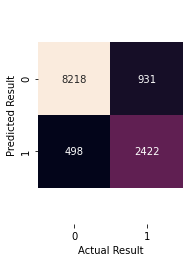

In [618]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [619]:
fbwx_w2v_rbf_SVM_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_rbf_SVM_performance
model_name = 'fbwx_w2v_rbf_SVM(gamma=1/k)'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df


,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069
fbwx_w2v_linear_SVM_naive_resampling,0.841163,0.666281,0.858038,0.750098,3353,0.938589,0.834672,0.883585,8716,0.802435,0.846355,0.816842,12069,0.862936,0.841163,0.846500,12069
fbwx_w2v_poly_SVM C=0.1,0.851272,0.849327,0.564867,0.678488,3353,0.851713,0.961450,0.903261,8716,0.850520,0.763159,0.790874,12069,0.851050,0.851272,0.840815,12069
fbwx_w2v_poly_SVM C=1,0.876295,0.833812,0.692812,0.756801,3353,0.889044,0.946879,0.917051,8716,0.861428,0.819846,0.836926,12069,0.873700,0.876295,0.872530,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.842158,0.666820,0.863108,0.752372,3353,0.940613,0.834098,0.884159,8716,0.803717,0.848603,0.818266,12069,0.864548,0.842158,0.847546,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.863286,0.708140,0.864002,0.778345,3353,0.942843,0.863011,0.901162,8716,0.825491,0.863506,0.839754,12069,0.877638,0.863286,0.867041,12069


### Model 3.8 现有样本训练Word2Vec + RBF_SVM + gamma = 1/k + Naive Resampling

In [620]:
startTime = time.time()
rbf_svm = SVC(kernel='rbf')
rbf_svm.fit(X_resampled_naive,y_resampled_naive)
usedTime = time.time() - startTime

In [621]:
print(usedTime)

687.4958000183105


In [622]:
y_pred_svm = rbf_svm.predict(test_X_svm)

In [623]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9437    0.8574    0.8985      8716
           1     0.7005    0.8670    0.7749      3353

    accuracy                         0.8601     12069
   macro avg     0.8221    0.8622    0.8367     12069
weighted avg     0.8761    0.8601    0.8641     12069



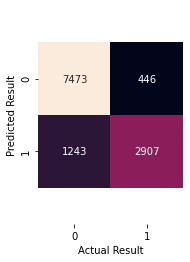

In [624]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [625]:
fbwx_w2v_rbf_SVM_naive_resampling_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_rbf_SVM_naive_resampling_performance
model_name = 'fbwx_w2v_rbf_SVM(gamma=1/k)_naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069
fbwx_w2v_linear_SVM_naive_resampling,0.841163,0.666281,0.858038,0.750098,3353,0.938589,0.834672,0.883585,8716,0.802435,0.846355,0.816842,12069,0.862936,0.841163,0.846500,12069
fbwx_w2v_poly_SVM C=0.1,0.851272,0.849327,0.564867,0.678488,3353,0.851713,0.961450,0.903261,8716,0.850520,0.763159,0.790874,12069,0.851050,0.851272,0.840815,12069
fbwx_w2v_poly_SVM C=1,0.876295,0.833812,0.692812,0.756801,3353,0.889044,0.946879,0.917051,8716,0.861428,0.819846,0.836926,12069,0.873700,0.876295,0.872530,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.842158,0.666820,0.863108,0.752372,3353,0.940613,0.834098,0.884159,8716,0.803717,0.848603,0.818266,12069,0.864548,0.842158,0.847546,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.863286,0.708140,0.864002,0.778345,3353,0.942843,0.863011,0.901162,8716,0.825491,0.863506,0.839754,12069,0.877638,0.863286,0.867041,12069


In [682]:
fbwx_w2v_rbf_SVM_naive_resampling_data = newvalues.copy()

In [683]:
fbwx_w2v_rbf_SVM_naive_resampling_data.shape

(60342, 4)

In [684]:
fbwx_w2v_rbf_SVM_naive_resampling_data['prediction'] = y_pred_svm

ValueError: Length of values (12069) does not match length of index (60342)

### Model 4.1 现有样本训练Word2Vec + XGBoost

In [626]:
import xgboost as xgb

In [627]:
train_X_xgb = train_X_svm.copy()
test_X_xgb = test_X_svm.copy()
train_y_xgb = train_y_svm.copy()
test_y_xgb = test_y_svm.copy()

In [628]:
train_X_xgb.shape

(48273, 200)

In [629]:
params={
'booster':'gbtree', 
# 这里手写数字是0-9，是一个多类的问题，因此采用了multisoft多分类器，
'objective': 'binary:logistic',  #二分类的逻辑回归问题，输出为概率
'eval_metric' : 'auc',
'gamma':0.05,  # 在树的叶子节点下一个分区的最小损失，越大算法模型越保守 。[0:]
'n_estimators' : 10,
'max_depth':4, # 构建树的深度 [1:] 需要用单颗树较少的深度来减少偏差 一般3-10 这里调低深度使得模型更为贪婪
#'lambda':450,  # L2 正则项权重
'subsample':0.7, # 采样训练数据，设置为0.5，随机选择一般的数据实例 (0:1]
'colsample_bytree':0.7, # 构建树树时的采样比率 (0:1]
#'min_child_weight':12, # 节点的最少特征数
'scale_pos_weight' : 2.349911190053286,
'silent':0 ,
'eta': 0.05, # 如同学习率http://localhost:8889/notebooks/Test.ipynb#
'seed':701,
'nthreads':-1,# cpu 线程数,根据自己U的个数适当调整
}

In [636]:
word2vec_gb_wx.label.value_counts()

0    43770
1    16572
Name: label, dtype: int64

In [637]:
sklearn_model_new = xgb.XGBClassifier(max_depth=5,
                                      learning_rate= 0.05, #0.0001到0.1之间 太小速度很慢
                                      verbosity=1, 
                                      objective='binary:logistic',
                                      subsample = 0.7,
                                      colsample_bytree = 0.7,
                                      scale_pos_weight = 43770/16572,
                                      random_state=1
                                     # 这里没有用到n_estimator, 因为用early_stopping_rounds使得auc最优)

In [638]:
train_X_xgb, val_X_xgb, train_y_xgb, val_y_xgb = train_test_split(X, y, test_size=0.05)

In [639]:
sklearn_model_new.fit(train_X_xgb, train_y_xgb, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(val_X_xgb, val_y_xgb)])

[0]	validation_0-auc:0.834877
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.87369
[2]	validation_0-auc:0.877923
[3]	validation_0-auc:0.883487
[4]	validation_0-auc:0.885268
[5]	validation_0-auc:0.887156
[6]	validation_0-auc:0.888427
[7]	validation_0-auc:0.888421
[8]	validation_0-auc:0.8882
[9]	validation_0-auc:0.888612
[10]	validation_0-auc:0.889117
[11]	validation_0-auc:0.890345
[12]	validation_0-auc:0.891183
[13]	validation_0-auc:0.891934
[14]	validation_0-auc:0.892814
[15]	validation_0-auc:0.893858
[16]	validation_0-auc:0.894098
[17]	validation_0-auc:0.894823
[18]	validation_0-auc:0.895078
[19]	validation_0-auc:0.895482
[20]	validation_0-auc:0.895415
[21]	validation_0-auc:0.896357
[22]	validation_0-auc:0.897197
[23]	validation_0-auc:0.897998
[24]	validation_0-auc:0.898762
[25]	validation_0-auc:0.899002
[26]	validation_0-auc:0.899427
[27]	validation_0-auc:0.899916
[28]	validation_0-auc:0.900265
[29]	validation_0-auc:0.900666
[30]	validation_0-a

XGBClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=5,
              random_state=1, scale_pos_weight=2.6412020275162926,
              subsample=0.7)

In [640]:
y_pred_xgb = sklearn_model_new.predict(test_X_xgb)

In [641]:
print(classification_report(test_y_xgb, y_pred_xgb,digits=4))

              precision    recall  f1-score   support

           0     0.9492    0.8237    0.8820      8716
           1     0.6589    0.8855    0.7556      3353

    accuracy                         0.8408     12069
   macro avg     0.8041    0.8546    0.8188     12069
weighted avg     0.8686    0.8408    0.8469     12069



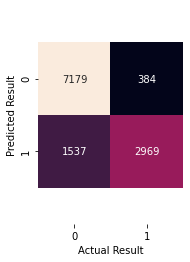

In [642]:
mat = confusion_matrix(y_pred_xgb,test_y_xgb)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [266]:
from sklearn.model_selection import GridSearchCV

In [332]:
paramGrid = {"max_depth" : [5,6,7,8,9,10]}
cv = 2

In [333]:
fit_params={"early_stopping_rounds":5, 
            "eval_metric" : "auc", 
            "eval_set" : [[val_X_xgb, val_y_xgb]]}

In [334]:
model = xgb.XGBRegressor(learning_rate= 0.05, 
                         verbosity=1,
                         objective='binary:logistic',
                         subsample = 0.7,
                         colsample_bytree = 0.7,
                         scale_pos_weight = 2.349911190053286,
                         random_state=1)

gridsearch = GridSearchCV(model, paramGrid, verbose=1,cv = 2,
                        n_jobs = -1)

gridsearch.fit(train_X_xgb, train_y_xgb, **fit_params)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.3min remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.0min finished


[0]	validation_0-auc:0.862506
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.883963
[2]	validation_0-auc:0.892269
[3]	validation_0-auc:0.899534
[4]	validation_0-auc:0.902337
[5]	validation_0-auc:0.905057
[6]	validation_0-auc:0.907803
[7]	validation_0-auc:0.908734
[8]	validation_0-auc:0.907833
[9]	validation_0-auc:0.9092
[10]	validation_0-auc:0.91059
[11]	validation_0-auc:0.911343
[12]	validation_0-auc:0.911638
[13]	validation_0-auc:0.91207
[14]	validation_0-auc:0.912862
[15]	validation_0-auc:0.913734
[16]	validation_0-auc:0.914234
[17]	validation_0-auc:0.91447
[18]	validation_0-auc:0.915312
[19]	validation_0-auc:0.91593
[20]	validation_0-auc:0.916336
[21]	validation_0-auc:0.917199
[22]	validation_0-auc:0.917462
[23]	validation_0-auc:0.917856
[24]	validation_0-auc:0.918561
[25]	validation_0-auc:0.918727
[26]	validation_0-auc:0.919605
[27]	validation_0-auc:0.920208
[28]	validation_0-auc:0.920403
[29]	validation_0-auc:0.921049
[30]	validation_0-auc:0

GridSearchCV(cv=2,
             estimator=XGBRegressor(colsample_bytree=0.7, learning_rate=0.05,
                                    objective='binary:logistic', random_state=1,
                                    scale_pos_weight=2.349911190053286,
                                    subsample=0.7),
             n_jobs=-1, param_grid={'max_depth': [5, 6, 7, 8, 9, 10]},
             verbose=1)

In [335]:
print(gridsearch.best_score_)
print(gridsearch.best_params_)

0.5112642258986644
{'max_depth': 9}


In [336]:
model = xgb.XGBRegressor(learning_rate= 0.05, 
                         verbosity=1,
                         objective='binary:logistic',
                         subsample = 0.7,
                         colsample_bytree = 0.7,
                         scale_pos_weight = 2.349911190053286,
                         random_state=1,
                        max_depth = 5)
model.fit(train_X_xgb, train_y_xgb, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(val_X_xgb, val_y_xgb)])
y_pred_xgb = model.predict(test_X_xgb)

[0]	validation_0-auc:0.849186
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.878202
[2]	validation_0-auc:0.877414
[3]	validation_0-auc:0.880505
[4]	validation_0-auc:0.883067
[5]	validation_0-auc:0.885838
[6]	validation_0-auc:0.888724
[7]	validation_0-auc:0.890981
[8]	validation_0-auc:0.891121
[9]	validation_0-auc:0.892434
[10]	validation_0-auc:0.893584
[11]	validation_0-auc:0.894864
[12]	validation_0-auc:0.895439
[13]	validation_0-auc:0.895722
[14]	validation_0-auc:0.895696
[15]	validation_0-auc:0.89571
[16]	validation_0-auc:0.89603
[17]	validation_0-auc:0.897556
[18]	validation_0-auc:0.898382
[19]	validation_0-auc:0.898597
[20]	validation_0-auc:0.899176
[21]	validation_0-auc:0.899345
[22]	validation_0-auc:0.899867
[23]	validation_0-auc:0.899843
[24]	validation_0-auc:0.900845
[25]	validation_0-auc:0.901522
[26]	validation_0-auc:0.90233
[27]	validation_0-auc:0.90262
[28]	validation_0-auc:0.903502
[29]	validation_0-auc:0.904483
[30]	validation_0-au

In [337]:
y_pred_xgb_label = []
for i in y_pred_xgb:
    if i >= 0.5:
        label = 1
        y_pred_xgb_label.append(label)
    else:
        label = 0
        y_pred_xgb_label.append(label)


In [338]:
print(classification_report(test_y_xgb, y_pred_xgb_label,digits=4))

              precision    recall  f1-score   support

           0     0.9467    0.8357    0.8878      4974
           1     0.6954    0.8885    0.7802      2099

    accuracy                         0.8514      7073
   macro avg     0.8210    0.8621    0.8340      7073
weighted avg     0.8721    0.8514    0.8558      7073



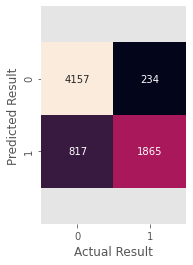

In [339]:
mat = confusion_matrix(y_pred_xgb_label,test_y_xgb)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [643]:
from xgboost import XGBClassifier
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [650]:
model = XGBClassifier(max_depth = 5,
                      learning_rate = 0.05,
                      n_estimators = 200,
                      colsample_bytree = 0.7,
                      subsample = 0.7,
                      scale_pos_weight =43770/16572,
                     random_state = 1)
eval_set = [(train_X_xgb, train_y_xgb), (val_X_xgb, val_y_xgb)]
model.fit(train_X_xgb, train_y_xgb, eval_metric=["error", "logloss",'auc'], eval_set=eval_set, verbose=False)

XGBClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=5,
              n_estimators=200, random_state=1,
              scale_pos_weight=2.6412020275162926, subsample=0.7)

In [651]:
y_pred = model.predict(test_X_xgb)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(test_y_xgb, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
results = model.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

Accuracy: 87.05%


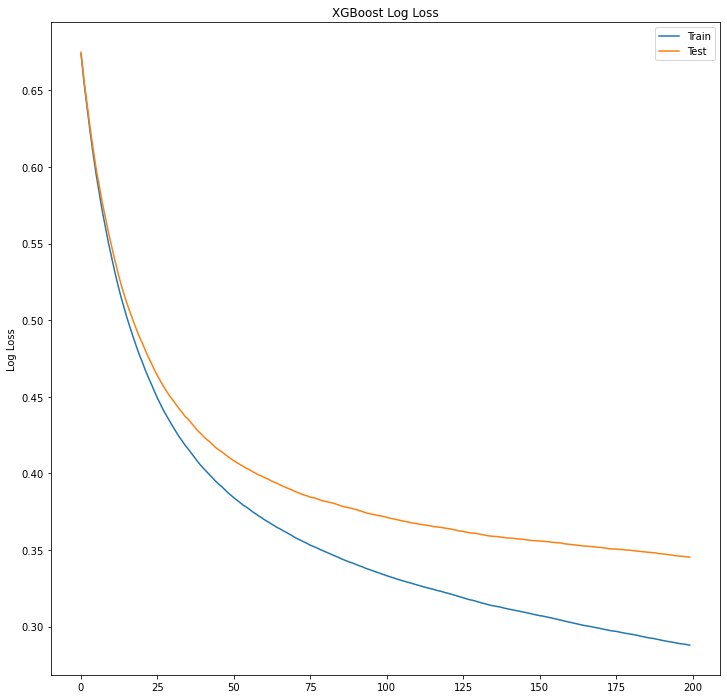

In [652]:
# plot log loss
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
pyplot.ylabel("Log Loss")
pyplot.title("XGBoost Log Loss")
pyplot.show()

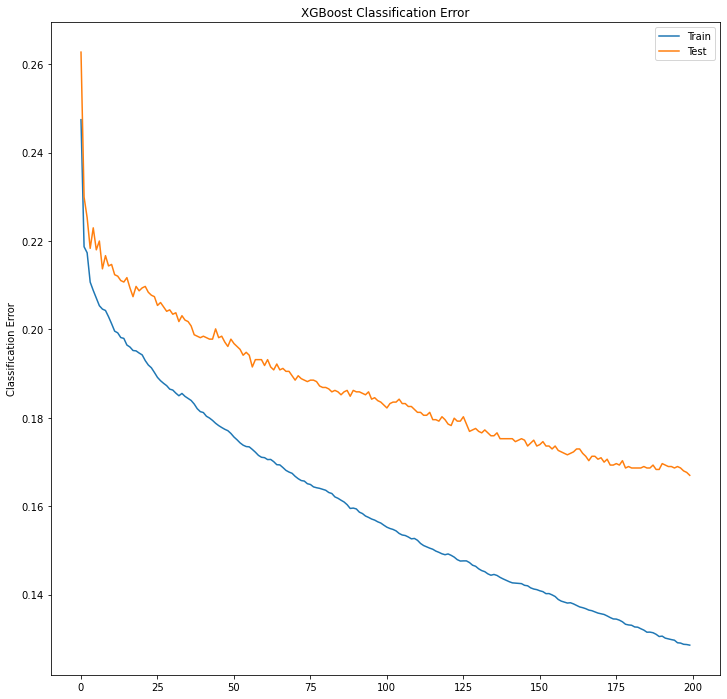

In [653]:
# plot classification error
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
pyplot.ylabel("Classification Error")
pyplot.title("XGBoost Classification Error")
pyplot.show()

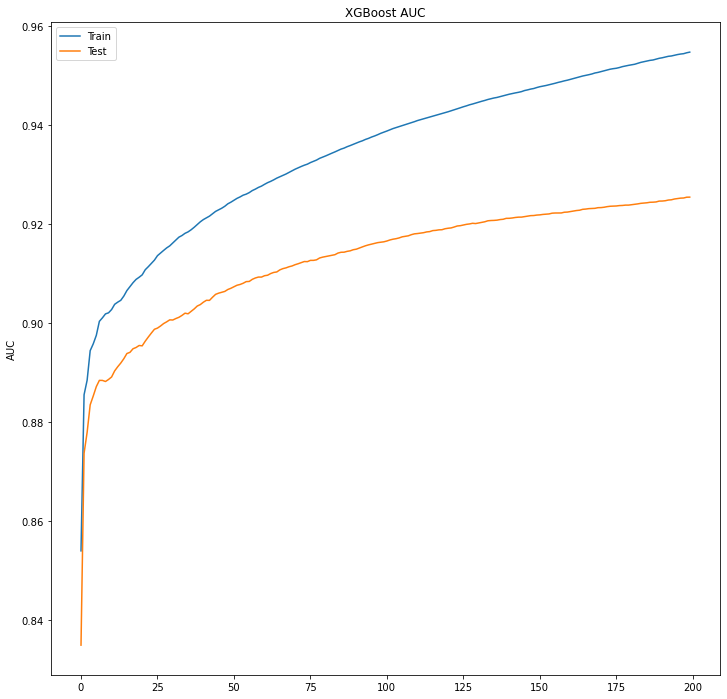

In [654]:
# plot log loss
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["auc"], label="Train")
ax.plot(x_axis, results["validation_1"]["auc"], label="Test")
ax.legend()
pyplot.ylabel("AUC")
pyplot.title("XGBoost AUC")
pyplot.show()

**XGBoost模型参数调优**

In [672]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional     scklearn functions
from sklearn.model_selection import GridSearchCV #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [673]:
target = 'Disbursed'
IDcol = 'ID'

In [675]:
def modelfit(alg, X,y, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
     
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
 
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
 
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
 
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

##### 第一步：确定学习速率和tree_based 参数调优的估计器数目。
为了确定boosting 参数，要先给其它参数一个初始值。先按如下方法取值：
1. max_depth = 5 :这个参数的取值最好在3-10之间。我选的起始值为5，但是你也可以选择其它的值。起始值在4-6之间都是不错的选择。
2. min_child_weight = 1:在这里选了一个比较小的值，因为这是一个极不平衡的分类问题。因此，某些叶子节点下的值会比较小。
3. gamma = 0: 起始值也可以选其它比较小的值，在0.1到0.2之间就可以。这个参数后继也是要调整的。
4. subsample,colsample_bytree = 0.8: 这个是最常见的初始值了。典型值的范围在0.5-0.9之间。
5. scale_pos_weight = 1: 这个值是因为类别十分不平衡。

注意: 上面这些参数的值只是一个初始的估计值，后继需要调优。这里把学习速率就设成默认的0.1。然后用xgboost中的cv函数来确定最佳的决策树数量。前文中的函数可以完成这个工作。

In [676]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target,IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

NameError: name 'train' is not defined

### Model 5.1 现有样本数据训练word2vec + Random Forest

In [656]:
from sklearn.ensemble import RandomForestClassifier
rfc_model=RandomForestClassifier()

In [655]:
train_X_rf = train_X_svm.copy()
test_X_rf = test_X_svm.copy()
train_y_rf = train_y_svm.copy()
test_y_rf = test_y_svm.copy()


In [658]:
startTime = time.time()
rfc_model.fit(train_X_rf,train_y_rf)
usedTime = time.time() - startTime
usedTime

73.7234570980072

In [659]:
y_pred_rf = rfc_model.predict(test_X_rf)

In [660]:
print(classification_report(test_y_rf, y_pred_rf,digits=4))

              precision    recall  f1-score   support

           0     0.8820    0.9444    0.9121      8716
           1     0.8228    0.6716    0.7396      3353

    accuracy                         0.8686     12069
   macro avg     0.8524    0.8080    0.8258     12069
weighted avg     0.8656    0.8686    0.8642     12069



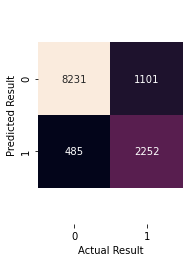

In [661]:
mat = confusion_matrix(y_pred_rf,test_y_rf)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [663]:
fbwx_w2v_rf_performance = classification_report(test_y_rf, y_pred_rf,digits=4,output_dict=True)
performance = fbwx_w2v_rf_performance
model_name = 'fbwx_w2v_Ramdom Forest'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069
fbwx_w2v_linear_SVM_naive_resampling,0.841163,0.666281,0.858038,0.750098,3353,0.938589,0.834672,0.883585,8716,0.802435,0.846355,0.816842,12069,0.862936,0.841163,0.846500,12069
fbwx_w2v_poly_SVM C=0.1,0.851272,0.849327,0.564867,0.678488,3353,0.851713,0.961450,0.903261,8716,0.850520,0.763159,0.790874,12069,0.851050,0.851272,0.840815,12069
fbwx_w2v_poly_SVM C=1,0.876295,0.833812,0.692812,0.756801,3353,0.889044,0.946879,0.917051,8716,0.861428,0.819846,0.836926,12069,0.873700,0.876295,0.872530,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.842158,0.666820,0.863108,0.752372,3353,0.940613,0.834098,0.884159,8716,0.803717,0.848603,0.818266,12069,0.864548,0.842158,0.847546,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.863286,0.708140,0.864002,0.778345,3353,0.942843,0.863011,0.901162,8716,0.825491,0.863506,0.839754,12069,0.877638,0.863286,0.867041,12069


### Model 5.2 现有样本数据训练word2vec + Random Forest + Random Naive Resampling

In [664]:
X_resampling = np.array(train_X_rf)
y_resampling = train_y_rf
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)

In [665]:
startTime = time.time()
rfc_model.fit(X_resampled_naive,y_resampled_naive)
usedTime = time.time() - startTime
usedTime

107.5807843208313

In [666]:
y_pred_rf = rfc_model.predict(test_X_rf)
print(classification_report(test_y_rf, y_pred_rf,digits=4))

              precision    recall  f1-score   support

           0     0.9016    0.9259    0.9136      8716
           1     0.7928    0.7373    0.7640      3353

    accuracy                         0.8735     12069
   macro avg     0.8472    0.8316    0.8388     12069
weighted avg     0.8714    0.8735    0.8720     12069



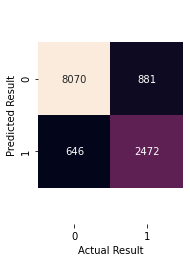

In [667]:
mat = confusion_matrix(y_pred_rf,test_y_rf)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [668]:
fbwx_w2v_rf_naive_resampling_performance = classification_report(test_y_rf, y_pred_rf,digits=4,output_dict=True)
performance = fbwx_w2v_rf_naive_resampling_performance
model_name = 'fbwx_w2v_Ramdom Forest naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069
fbwx_w2v_linear_SVM_naive_resampling,0.841163,0.666281,0.858038,0.750098,3353,0.938589,0.834672,0.883585,8716,0.802435,0.846355,0.816842,12069,0.862936,0.841163,0.846500,12069
fbwx_w2v_poly_SVM C=0.1,0.851272,0.849327,0.564867,0.678488,3353,0.851713,0.961450,0.903261,8716,0.850520,0.763159,0.790874,12069,0.851050,0.851272,0.840815,12069
fbwx_w2v_poly_SVM C=1,0.876295,0.833812,0.692812,0.756801,3353,0.889044,0.946879,0.917051,8716,0.861428,0.819846,0.836926,12069,0.873700,0.876295,0.872530,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.842158,0.666820,0.863108,0.752372,3353,0.940613,0.834098,0.884159,8716,0.803717,0.848603,0.818266,12069,0.864548,0.842158,0.847546,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.863286,0.708140,0.864002,0.778345,3353,0.942843,0.863011,0.901162,8716,0.825491,0.863506,0.839754,12069,0.877638,0.863286,0.867041,12069


### Model 6.1 现有样本数据训练word2vec + Extra Trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
et_model=ExtraTreesClassifier()

### Model 7.1 现有样本数据训练word2vec + Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb_model=GaussianNB()

### Model 8.1 现有样本数据训练word2vec + KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model=KNeighborsClassifier()

### Model 4.1: zhihu word vectors + cnn

#### 0.需要的库

In [ ]:
# 首先加载必用的库，jieba和gensim专门中文 
# %matplotlib inline功能是可以内嵌绘图，并且可以省略掉plt.show()这一步
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import re #正则化用
import jieba # 中文必须用【结巴分词】，因为计算机不会断句
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
#KeyedVectors实现实体（单词、文档、图片都可以）和向量之间的映射，实体都用string id表示
#有时候运行代码时会有很多warning输出，如提醒新版本之类的，如果不想乱糟糟的输出可以这样
import warnings
warnings.filterwarnings("ignore")

#### 1.预训练词向量

In [ ]:
cn_model = KeyedVectors.load_word2vec_format('sgns.zhihu.bigram', 
                                          binary=False)

#### 2.词向量模型

In [ ]:
# 由此可见每一个词都对应一个长度为300的向量
embedding_dim = cn_model['建筑'].shape[0]  #一词山东大学，shape[0]返回行数
print('词向量的长度为{}'.format(embedding_dim))
#cn_model['建筑']

In [ ]:
# 计算相似度
cn_model.similarity('伤亡', '事故')

In [ ]:
# dot（'橘子'/|'橘子'|， '橙子'/|'橙子'| ），余弦相似度
np.dot(cn_model['伤亡']/np.linalg.norm(cn_model['伤亡']), 
cn_model['事故']/np.linalg.norm(cn_model['事故']))

In [ ]:
# 找出最相近的词，余弦相似度
cn_model.most_similar(positive=['事故'], topn=10)

In [ ]:
# 找出不同的词
test_words = '事故 故障 爆炸事件 死亡 建筑'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

In [ ]:
cn_model.most_similar(positive=['建筑','事故'], negative=['工程'], topn=1)

#### 3.训练语料 （数据集）

In [ ]:
# 我们使用tensorflow的keras接口来建模
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional#Dense全连接
#Bidirectional双向LSTM  callbacks用来调参
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import models

In [ ]:
# 我们使用tensorflow的keras接口来建模
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional#Dense全连接
#Bidirectional双向LSTM  callbacks用来调参
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


#### 4.分词和tokenize

In [ ]:
train_tokens = newvalues['baidu_seg'].tolist()

In [ ]:
train_tokens = []
for row_idx in range(newvalues.shape[0]):
    cut_list = newvalues.loc[row_idx, 'baidu_seg'].copy()
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
    train_tokens.append(cut_list)

In [ ]:
newvalues.loc[0, 'baidu_seg']

#### 5.索引长度标准化
因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评填充成同样的长度，这样十分浪费计算资源，所以我们取一个折衷的长度。

In [ ]:
# 获得所有tokens的长度
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)


In [ ]:
# 平均tokens的长度
np.mean(num_tokens)

In [ ]:
# 最长的评价tokens的长度
np.max(num_tokens)

In [ ]:
plt.hist(np.log(num_tokens), bins = 100)#有大有小取对数
plt.xlim((3,6))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [ ]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

In [ ]:
# 取tokens的长度为1806时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

#### 6.反向tokenize
为了之后来验证 我们定义一个function，用来把索引转换成可阅读的文本，这对于debug很重要。

In [ ]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text


In [ ]:
reverse = reverse_tokens(train_tokens[100])
reverse

In [ ]:
newvalues.loc[100, 'baidu_seg']

#### 7.构建embedding matrix
现在我们来为模型准备embedding matrix（词向量矩阵），根据keras的要求，我们需要准备一个维度为(numwords, embeddingdim)的矩阵【num words代表我们使用的词汇的数量，emdedding dimension在我们现在使用的预训练词向量模型中是300，每一个词汇都用一个长度为300的向量表示】注意我们只选择使用前50k个使用频率最高的词，在这个预训练词向量模型中，一共有260万词汇量，如果全部使用在分类问题上会很浪费计算资源，因为我们的训练样本很小，一共只有4k，如果我们有100k，200k甚至更多的训练样本时，在分类问题上可以考虑减少使用的词汇量。

In [ ]:
# 只使用大库前50000个词
num_words = 100000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')


In [ ]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum( cn_model[cn_model.index2word[333]] == embedding_matrix[333] )

In [ ]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

In [ ]:
train_tokens[0]

In [ ]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')


In [ ]:
len(train_pad[1])

In [ ]:
pd.DataFrame(train_pad[11]).shape

In [ ]:
# 超出9000个词向量的词用0代替
train_pad[train_pad >= num_words ] = 0

In [ ]:
# 可见padding之后前面的tokens全变成0，文本在最后面
train_pad[1003]

In [ ]:
# pd.DataFrame(train_pad[10])[0].value_counts()
# 训练样本专业性很强，而预训练的词向量所用文本包含许多领域

In [ ]:
train_target = newvalues.label

In [ ]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split


In [ ]:
train_target.shape
train_pad.shape

In [ ]:
# 90%的样本用来训练，剩余10%用来测试
#因为前2000个文件夹都是neg一类，所以打乱顺序来训练 random_state
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12
                                                    )


In [ ]:
import random
X_train = random.sample(train_pad.tolist(), train_pad.shape[0]*0.7) # 结果['a', 'd', 'b', 'f', 'c']，每次运行结果不同。

In [ ]:
reverse = reverse_tokens(train_tokens[0])
reverse